In [ ]:
!conda install -c intel scikit-learn

# Training a sentiment analysis classifier based on supervised machine learning algorithms

In [1]:
import string

import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.neural_network import MLPClassifier

from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score

In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
stop_words = set(stopwords.words('spanish'))

In [4]:
def tokenizer(text):
    tt = TweetTokenizer()
    return tt.tokenize(text)

### Loading labeled tweets

In [5]:
# Dataset loaded from: https://docs.google.com/spreadsheets/d/11_E2ngsEOyTQwbwVVRHY5urzFF95BQCV/edit#gid=1788161364
tweets_df = pd.read_csv('./data/tweets_escenario1.2.csv', sep = ',')

In [6]:
tweets_df.shape

(627, 3)

In [7]:
tweets_df.head()

,full_text,sentiment,emotion
0,"@IvanDuque Sus socios de las AGC tienen este platanal vuelto mierda, pero no haces nada, usted inservible, ha logrado la peor inflación en Colombia y solo pública maricadas sin sentido, se robó las elecciones para entregar el país, valiente idiota tenemos de presidente.",negative,anger
1,@AlvaroUribeVel Ellos también celebran por que Maduro PetroGustavo Ivan Cepeda Timo Teodora Bobolivar entre muchos más sufren de insomnio.\nUribe Velez Alvarito no los deja dormir\nEl enemigo para las elecciones no es Fico.... Sino el Excelentísimo y más Grande Presidente que ha tenido Colombia,negative,anger
2,"@PDleh @cokycafe @PGN_COL En Colombia existen miles de leyes para controlar los funcionarios públicos pero a la hora de aplicarlas ""se les olvida que existen"". ¿Que más pruebas quieren? ¿Porque avalan unas elecciones, las del 13 de marzo, donde pado de todo lo que no debía de pasar? Escuchamos respuestas",negative,anger
3,Petro ahora es el Capitán América o mejor dicho el Capitán Colombia de ganar las elecciones. No soltara el escudo ni para dormir 😂 https://t.co/k56Dv7id1J,negative,joy
4,"#OtraPregunta \n""Petro promete reanudar relaciones diplomáticas con Maduro si gana elecciones en Colombia""...\nEsto no pinta nada bien... y si además gana Lula en Brasil...\n¿Esto como que va para largo? https://t.co/wpQsl5KoRe",negative,fear


In [8]:
tweets_df.sample(n=500, random_state=5)

,full_text,sentiment,emotion
445,#QuienRespondePor\nQueman carro de @UNALOficial Universidad Nacional en Santa Fe de Antioquia. El @COL_EJERCITO y la @PoliciaColombia Se escondieron no Actúan Parece ser el excenario para una Guerra Civil y así evitar Elecciones Presidenciales en Colombia @bbcmundo https://t.co/SWEo3DvigS,negative,joy
230,En Colombia hace falta un presidente como @nayibbukele que no le teme a nada y va de frente contra las fuerzas oscuras aliadas con políticos que lo único que buscas es inestabilidad en el país previo a elecciones.,positive,sadness
289,O sea que el miserable de Macías reconoce que en Colombia es Fácil robar elecciones. Bellaco.,negative,anger
622,"En los consulados de Colombia en el exterior se adelantan las pruebas de funcionalidad para las elecciones de presidente y vicepresidente de la república. En el país, la Registraduría Nacional alista los simulacros para los comicios del 29 de mayo.\n\n#GarantesDeLaDemocracia https://t.co/7NOQaPod0z",neutral,joy
361,"Exigimos garantías para la vida y la democracia. A 24 días de elecciones, #Colombia se encuentra sitiada por las mafias del #ClanDelGolfo sin que el gobierno haga nada! Pedimos a la comunidad internacional pronunciarse inmediatamente.\n\n@WOLA_org #QuienRespondePor #ParoArmado https://t.co/G6qEJKkpcU",negative,anger
...,...,...,...
192,"@PuertaRestrepo4 Pilas amigos colombianos que este tipo @MashiRafael se robó desde la esperanza hasta la banda presidencial de El Ecuador, de billete ni hablar suerte en las elecciones x una colombia sin comunismo",negative,fear
572,"Esto es Colombia hace 50 años, Colombia hace una decada, Colombia todos los días. esto señoras y señores es Colombia a unos cuantos días de elecciones presidenciales en las que "" el candidato de la oposición "" lidera todas las encuestas y los corruptos de siempre no lo soportan. https://t.co/cfHiZMPhbF",negative,anger
54,"fallas que encontró @PGN_COL en elecciones a Congreso https://t.co/6dpBhQIKtW y a pesar de todo los aliados de Petro.. Tibisay Lucena C @CNE_COLOMBIA @Doris_MendezC son tan descarados en afirmar que Las elecciones de congreso fueron transparentes , nos van a robar de nuevo",negative,anger
19,@IvanDuque Quien da vía libre a paramilitares para sitiar a Colombia y y afectar elecciones @ONUHumanRights @MisionONUCol @Declaracion @RIDH_INHR @CorteIDH @OACNUDH https://t.co/fZ2yFvjIwY,negative,fear


In [9]:
df2 = tweets_df.sample(n=500).copy()
len(df2)

500

In [10]:
#df2.to_csv('Dataset.csv')

In [11]:
df2['sentiment'].value_counts(dropna = False, normalize = True)

negative    0.678
neutral     0.268
positive    0.054
Name: sentiment, dtype: float64

In [12]:
df2['emotion'].value_counts(dropna = False, normalize = True)

anger      0.374
fear       0.230
sadness    0.208
joy        0.188
Name: emotion, dtype: float64

### Leaving out unlabeled texts, this data is not useful for training or validating a supervised model

In [13]:
# Removing  unlabeled tweets
tweets_labeled_df = df2.loc[df2['sentiment'].notnull()]

In [14]:
tweets_labeled_df.shape

(500, 3)

In [15]:
tweets_unlabeled_df = df2.loc[df2['sentiment'].isnull()]

In [16]:
tweets_unlabeled_df.shape

(0, 3)

In [17]:
# Scenario 1: Working with all classes

# Scenario 2: Working only with positive and negative classes
# Removing neutral class
#tweets_labeled_df = tweets_labeled_df.loc[tweets_labeled_df['sentiment'].isin(['positive', 'negative'])]

# Scenario 3: Treating neutral as positive classes
#tweets_labeled_df['sentiment'] = tweets_labeled_df['sentiment'].replace({'neutral': 'positive'})

### Splitting train and test datasets

In [18]:
X_train, X_test, y_train, y_test = train_test_split(tweets_labeled_df['full_text'], tweets_labeled_df['sentiment'], test_size = 0.2, stratify = tweets_labeled_df['sentiment'], random_state = 1)


In [19]:
X_train.shape

(400,)

In [20]:
pd.Series(y_train).value_counts(normalize = True)

negative    0.6775
neutral     0.2675
positive    0.0550
Name: sentiment, dtype: float64

In [21]:
X_test.shape

(100,)

In [22]:
pd.Series(y_test).value_counts(normalize = True)

negative    0.68
neutral     0.27
positive    0.05
Name: sentiment, dtype: float64

### Vectorizing texts

<table>
    <tbody>
        <tr>
            <td>
                <h4>Bag of Words</h4>
                <img src="./imgs/bow.png" style="width: 500px;">
            </td>
            <td>
                <h4>TF-IDF</h4>
                <img src="./imgs/tf-idf.png" style="width: 500px;">
            </td>
        </tr>
    </tbody>
</table>

In [23]:
bow = CountVectorizer(tokenizer = tokenizer, stop_words = stop_words)

In [24]:
tfidf = TfidfVectorizer(tokenizer = tokenizer, stop_words = stop_words)

In [25]:
X_bow = bow.fit_transform(X_train)

In [26]:
X_tfidf = tfidf.fit_transform(X_train)

### Training and evaluating a model using BOW

In [27]:
model = MLPClassifier()

In [28]:
model.fit(X_bow, y_train)

MLPClassifier()

In [29]:
y_train_bow_predict = model.predict(X_bow)
y_test_bow_predict = model.predict(bow.transform(X_test))

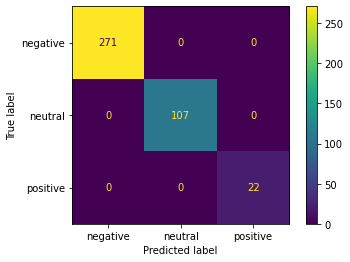

In [30]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_bow_predict)

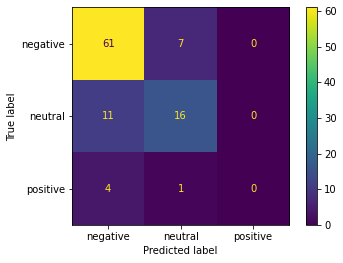

In [31]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_bow_predict)

In [ ]:
# Metrics calculation for binary classes
print('Precision:', precision_score(y_test, y_test_bow_predict, pos_label = 'positive'))
print('Recall:', recall_score(y_test, y_test_bow_predict, pos_label = 'positive'))
print('F1:', f1_score(y_test, y_test_bow_predict, pos_label = 'positive'))

In [32]:
# Metrics calculation for more than two classes
print('Precision:', precision_score(y_test, y_test_bow_predict, average = None))
print('Recall:', recall_score(y_test, y_test_bow_predict, average = None))
print('F1:', f1_score(y_test, y_test_bow_predict, average = None))

Precision: [0.80263158 0.66666667 0.        ]
Recall: [0.89705882 0.59259259 0.        ]
F1: [0.84722222 0.62745098 0.        ]


C:\Users\Juan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Training and evaluating a model using TF-IDF

In [33]:
model = MLPClassifier()

In [34]:
model.fit(X_tfidf, y_train)

MLPClassifier()

In [35]:
y_train_tfidf_predict = model.predict(X_tfidf)
y_test_tfidf_predict = model.predict(bow.transform(X_test))

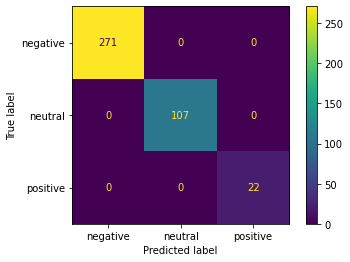

In [36]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_tfidf_predict)

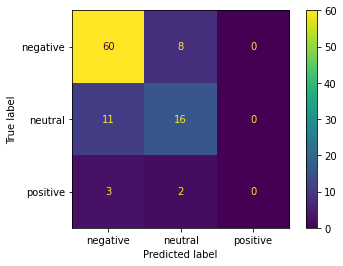

In [37]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_tfidf_predict)

In [ ]:
# Metrics calculation for binary classes
print('Precision:', precision_score(y_test, y_test_tfidf_predict, pos_label = 'positive'))
print('Recall:', recall_score(y_test, y_test_tfidf_predict, pos_label = 'positive'))
print('F1:', f1_score(y_test, y_test_tfidf_predict, pos_label = 'positive'))

In [38]:
# Metrics calculation for more than two classes
print('Precision:', precision_score(y_test, y_test_tfidf_predict, average = None))
print('Recall:', recall_score(y_test, y_test_tfidf_predict, average = None))
print('F1:', f1_score(y_test, y_test_tfidf_predict, average = None))

Precision: [0.81081081 0.61538462 0.        ]
Recall: [0.88235294 0.59259259 0.        ]
F1: [0.84507042 0.60377358 0.        ]


C:\Users\Juan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### How interpret the results?

<table>
    <tbody>
        <tr>
            <td>
                <img src="./imgs/confusion-matrix.png" style="height: 400px;">
            </td>
            <td>
                <img src="./imgs/precision-recall.png" style="height: 600px;">
            </td>
        </tr>
    </tbody>
</table>

### Analyzing errors

In [39]:
error_df = pd.concat(
    [ pd.concat([X_test, y_test ], axis = 1).reset_index(),
    pd.Series(y_test_bow_predict) ]
, axis = 1).rename(columns = { 'sentiment': 'actual', 0: 'predicted' })

error_df.drop('index', inplace = True, axis = 1)

In [40]:
error_df.shape

(100, 3)

In [41]:
error_df.loc[error_df['actual'] != error_df['predicted']].head(100)

,full_text,actual,predicted
1,@JulianFMartinez @DNP_Colombia @aleboterob Estaban esperando el momento preciso. Las elecciones.,neutral,negative
7,@MariaFdaCabal y para distraer de las elecciones dónde Colombia eligió ya Presidente 2022-2026 @FicoGutierrez https://t.co/3fcppGX1EY,neutral,negative
15,Se quitó la careta. .......Petro promete reanudar relaciones diplomáticas con Maduro si gana elecciones en Colombia https://t.co/68tVxXzgeM,negative,neutral
19,"El comunista @petrogustavo se quitó la careta este viernes y dijo que si gana las elecciones del #29Mayo en #Colombia reconocerá y trabajará diplomáticamente con el dictador @NicolasMaduro\n\n#Colombianos, no permitan que llegue el #Comunismo en su país.\n\nVoten por @FicoGutierrez https://t.co/IDWS9UoyaG",neutral,negative
27,Petro promete reanudar relaciones diplomáticas con Maduro si gana elecciones en Colombia\n#TalCual #ClaroyRaspao #AmigosDeNuevo \nhttps://t.co/Kpm7VZydwZ https://t.co/xyy0uPwwzZ,negative,neutral
29,"35 municipios, en seis departamentos, paralizados por paro armado del Clan del Golfo. \n\nColombia, con la inflación más alta en 22 años.\n\nCaos por Ley de garantías durante elecciones.\n\nBenito lanzó disco de 23 canciones.\n\nTaylor Swift estrena This Love TV, de su ya grammy 1989\n\n🥵",negative,neutral
41,"@_RoqueCastro Roque visualiza tu candidato ganador,visualiza la victoria de COLOMBIA. No declaren a ese hombre ganador. Trabajen su localidad Colombia está a Tiempo de salvar su pellejo y bueno toca trabajar duro..en estos días que quedan para las elecciones. 💪💫🙏🙌",positive,negative
43,"¿Por qué cree usted que debe ser suspendido Alexander Vega, Registrador Nacional del Estado Civil a 23 días de las elecciones presidenciales en Colombia? Responde el abogado constitucionalista ➡️ @Germancalderon1 en diálogo con @JeffersonNTN24 Directora @CGurisattiNTN24 ⬇️ https://t.co/HpbMJ16s1T",neutral,negative
46,#Elecciones2022\nEn Comité de Seguimiento Electoral de cara a las elecciones del 29 de mayo nuevas conclusiones y peticiones. @MagdalenaGober\n@SantaMartaDTCH\n@Registraduria\n@CNE_COLOMBIA\n👇\n“La Democracia es un compromiso de todos”: @rmontoyai Infante https://t.co/f3XcwEB599,neutral,negative
50,En el Encuentro conocimos el Informe de Participación Política de las Mujeres en Elecciones 2022.\n\nNos complace ver que el @PartidoMIRA sigue siendo un referente de participación política real de la mujer en Colombia 🇨🇴 @carlos_guevara @Virguez @AnaPaolaAgudelo @aydeelizarazoc https://t.co/5D40b9TSAC,positive,neutral
